# Projet 5 : Analyse exploratoire et cleaning

## Introduction

En tant que consultant pour Olist, une entreprise brésilienne en pleine expansion offrant une solution de vente sur les marketplaces en ligne. L'objectif étant d'aider à établir une équipe Data et à élaborer leur premier projet de Data Science axé sur la segmentation client. 

Nous allons donc maintenant pouvoir plonger dans la segmentation client. Mais avant de commnecer il va nous falloir explorer au mieux les données qui nous ont étaient fournies et les nettoyer. Dans un second temps et dans un autre notebook nous pourrons commencer à segmenter ces clients aevc un maximum de pertinence, en utilisant des méthodes non supervisées (kmeans...) pour regrouper les clients selon leurs comportements et leurs données personnelles, on créera par conséquent des catégories exploitables par l'équipe Marketing pour une communication plus ciblée et efficace. 

#### Importation des librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns

#### Importation du fichier à étudier

In [2]:
data = "olist.db"

# Connexion à la base de données
engine = create_engine(f"sqlite:///{data}")

# Visualisation d'une table pour vérification
customers = "customers"

# Création d'un data frame pour lire la table
df = pd.read_sql_table(customers, con=engine)

# Affichage du DataFrame
df.head()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Analyse exploratoire

In [3]:
# Ici nous avons une fonction qui permet d'obtenir le nombre de lignes et de colonnes de chaque table comprise dans notre base de données

def get_table_info():
    query = """
    SELECT
        name AS table_name,
        sql
    FROM
        sqlite_master
    WHERE
        type='table'
    """
    tables = pd.read_sql_query(query, engine)

    # l'objectif ici est de récupérer le nombre de lignes et de colonnes pour chaque table
    table_info = []
    for table_name in tables['table_name']:
        table_query = f"SELECT COUNT(*) AS num_rows, COUNT(*) AS num_columns FROM {table_name};"
        info = pd.read_sql_query(table_query, engine)
        table_info.append({
            'table_name': table_name,
            'num_rows': info['num_rows'][0],
            'num_columns': info['num_columns'][0]
        })

    return pd.DataFrame(table_info)

# On appelle la fonction et affichage des résultats
table_info = get_table_info()
print(table_info)

      table_name  num_rows  num_columns
0      customers     99441        99441
1         geoloc   1000163      1000163
2    order_items    112650       112650
3    order_pymts    103886       103886
4  order_reviews     99224        99224
5         orders     99441        99441
6       products     32951        32951
7        sellers      3095         3095
8    translation        71           71


Grâce à cela nous avons une idée plus claire de ce que contient nos différentes tables.

### Analyse exploratoire

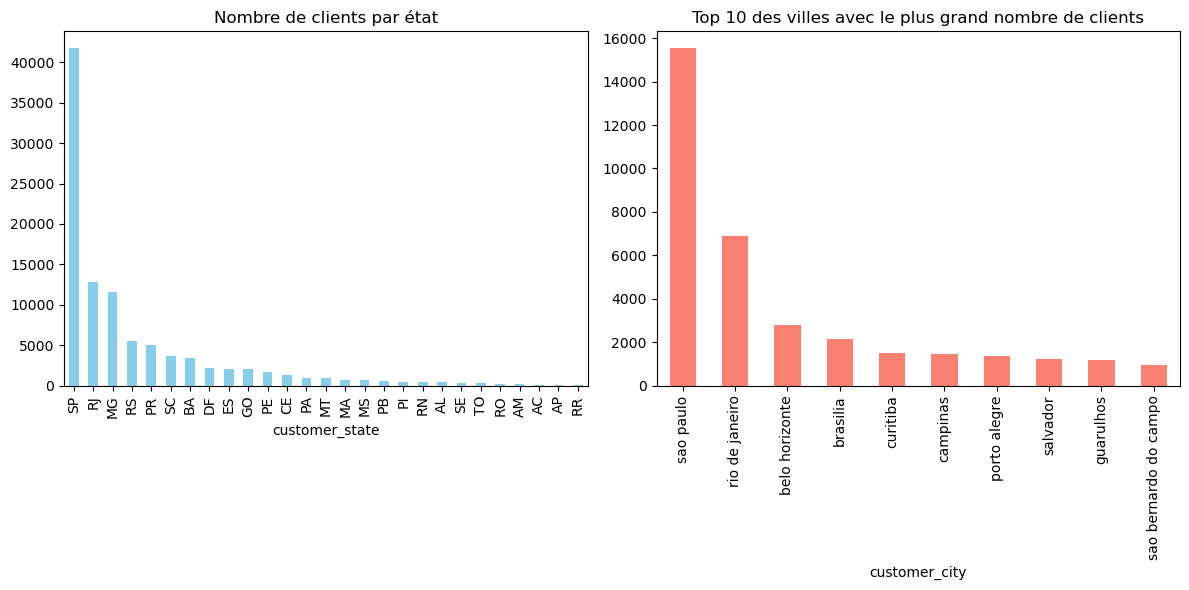

In [5]:
customers = "customers"

# Lire la table dans un DataFrame
df = pd.read_sql_table(customers, con=engine)

# Visualisation des données
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['customer_state'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Nombre de clients par état')

plt.subplot(1, 2, 2)
df['customer_city'].value_counts().head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 des villes avec le plus grand nombre de clients')

plt.tight_layout()
plt.show()

Nous pouvons voir ici que la ville la plus représentée est sao paulo et de loin suivie de rio de janeiro. 

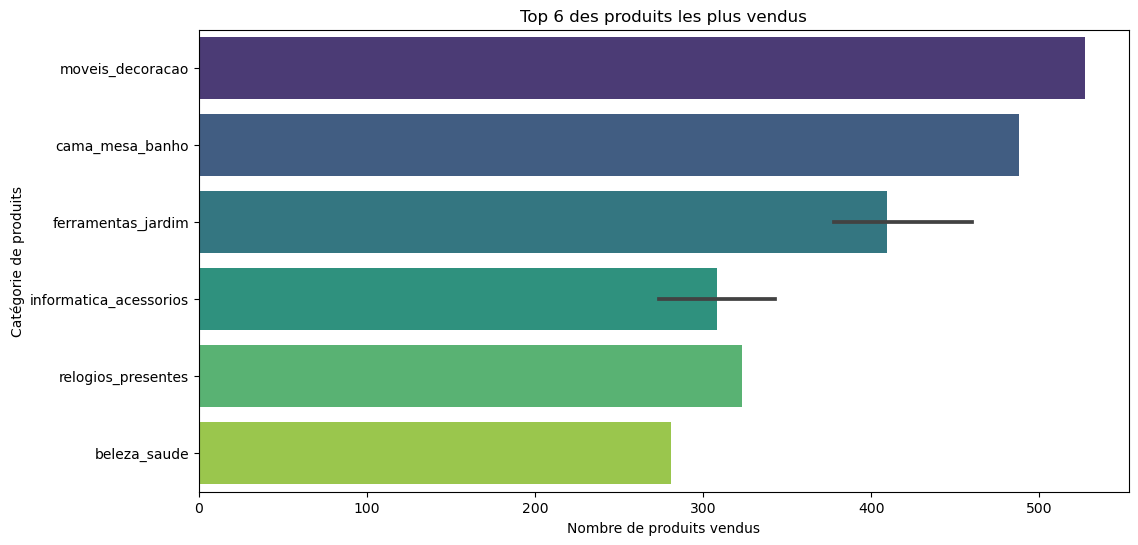

In [6]:
### Ici nous chercons à voir quels sont les produits les plus populaires, encore une fois nous utilisons un language SQL

# Analyse des produits populaires 
query_products = """
SELECT
    oi.product_id,
    p.product_category_name,
    COUNT(oi.order_item_id) AS total_sold
FROM
    order_items oi
JOIN
    products p ON oi.product_id = p.product_id
GROUP BY
    oi.product_id
ORDER BY
    total_sold DESC
LIMIT 10;
"""
df_products = pd.read_sql_query(query_products, engine)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x='total_sold', y='product_category_name', data=df_products, palette='viridis')
plt.title('Top 6 des produits les plus vendus')
plt.xlabel('Nombre de produits vendus')
plt.ylabel('Catégorie de produits')
plt.show()

On se rend compte que ce qui se vend le plus en termes de quantité sont les meubles de décoration, ainsi que les lits, les tables de bain, les outils de jardin, les accessoires informatiques, et ainsi de suite. On voit bien que l'on retrouve un peu de tout sur ce site.

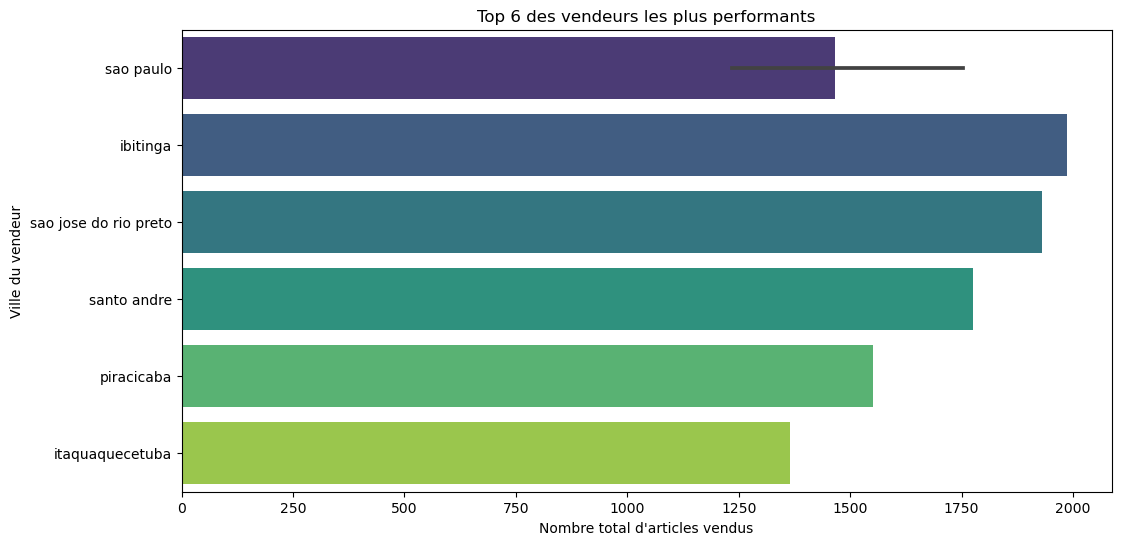

In [7]:
# Maintenant nous allons essayé d'analyser les vendeurs les plus populaires par ville
query_sellers = """
SELECT
    oi.seller_id,
    s.seller_city,
    s.seller_state,
    COUNT(oi.order_item_id) AS total_sold
FROM
    order_items oi
JOIN
    sellers s ON oi.seller_id = s.seller_id
GROUP BY
    oi.seller_id
ORDER BY
    total_sold DESC
LIMIT 10;
"""
df_sellers = pd.read_sql_query(query_sellers, engine)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x='total_sold', y='seller_city', data=df_sellers, palette='viridis')
plt.title('Top 6 des vendeurs les plus performants')
plt.xlabel('Nombre total d\'articles vendus')
plt.ylabel('Ville du vendeur')
plt.show()

Encore une fois nous retrouvons la ville de sao paulo dans le top des meilleurs vendeurs avec également ibitinga ou encore santo andre.

### Création de notre dataframe 

Nous allons maintenant créer notre DataFrame sur lequel nous devrons travailler par la suite. Pour ce faire, nous devons "assembler" toutes ces différentes tables.

In [8]:
# Chargement des tables
sellers_df = pd.read_sql_table("sellers", con=engine)
customers_df = pd.read_sql_table("customers", con=engine)
geoloc_df = pd.read_sql_table("geoloc", con=engine)
order_items_df = pd.read_sql_table("order_items", con=engine)
order_pymts_df = pd.read_sql_table("order_pymts", con=engine)
order_reviews_df = pd.read_sql_table("order_reviews", con=engine)
orders_df = pd.read_sql_table("orders", con=engine)
products_df = pd.read_sql_table("products", con=engine)
translation_df = pd.read_sql_table("translation", con=engine)

# Fusion de nos différentes tables
merged_df = pd.merge(orders_df, customers_df, on="customer_id", how="inner")
merged_df = pd.merge(merged_df, order_items_df, on="order_id", how="inner").drop("index_x", axis=1)
merged_df = pd.merge(merged_df, order_pymts_df, on="order_id", how="inner").drop("index_x", axis=1)
merged_df = pd.merge(merged_df, order_reviews_df, on="order_id", how="inner")
merged_df = pd.merge(merged_df, products_df, on="product_id", how="inner")
merged_df = pd.merge(merged_df, sellers_df, on="seller_id", how="inner").drop("index_x", axis=1)
merged_df = pd.merge(merged_df, translation_df, on="product_category_name", how="inner")

# Affichage des premières lignes du DataFrame fusionné pour la vérification
print(merged_df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   index_y                        115609 non-null  int64  
 9   customer_unique_id             115609 non-null  object 
 10  customer_zip_code_prefix       115609 non-null  int64  
 11  customer_city                  115609 non-null  object 
 12  customer_state                

Comme nous avons pu le vérifier, il semble que la fusion a bien fonctionné. Nous pouvons maintenant vérifier que nous n'avons aucun doublon.

In [10]:
merged_df.duplicated().sum()

0

Nous avons 0 doublons nous pouvons donc continuer.

### Utilisation de RFM pour le ciblage marketing.

Tout d'abord je décide d'utiliser la méthode RFM pour voir comment notre prédécesseur avais fait et pour avoir une idée de la répartition des clients.

In [11]:
### Pour commencer on remplace les valeurs nulles pour éviter tous problèmes

# Convertion de la colonne 'order_delivered_customer_date' en type datetime
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'], errors='coerce')

# Calcul de la date médiane
median_date = merged_df['order_delivered_customer_date'].median()

# Remplacement des valeurs manquantes par la date médiane
merged_df['order_delivered_customer_date'].fillna(median_date, inplace=True)

In [12]:
### Dans ce script nous voulons créer la récense, la fréquences et la variable monetary pour pouvoir justement faire notre RFM

# Ici l'objectif est de trouver la dernière date connue dans la colonne 'order_delivered_customer_date'
last_order_date = merged_df['order_delivered_customer_date'].max()

# Calcul de la récence en utilisant la date la plus récente comme référence
recency_df = merged_df.groupby('customer_id')['order_delivered_customer_date'].max().reset_index()
recency_df['recency'] = (last_order_date - recency_df['order_delivered_customer_date']).dt.days

# Fréquence
frequency_df = merged_df.groupby('customer_id')['order_id'].nunique().reset_index()
frequency_df.columns = ['customer_id', 'frequency']

# Valeur Monétaire (monetary)
monetary_df = merged_df.groupby('customer_id')['price'].sum().reset_index()
monetary_df.columns = ['customer_id', 'monetary']

# Fusion des résultats
rfm_df = pd.merge(recency_df[['customer_id', 'recency']], frequency_df, on='customer_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='customer_id')

# Création de segments RFM
rfm_df['R_Score'] = pd.qcut(rfm_df['recency'], q=5, labels=False, duplicates='drop') + 1
rfm_df['F_Score'] = pd.cut(rfm_df['frequency'], bins=5, labels=False, include_lowest=True)
rfm_df['M_Score'] = pd.qcut(rfm_df['monetary'], q=5, labels=False, duplicates='drop') + 1

In [13]:
# Calcul du score RFM global
rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

# Assignation des segments RFM
segment_labels = ['A risque', 'A réactiver', 'Loyalistes potentiels', 'Loyaux', 'Champions'] # Création des noms des segments
segment_bins = [float('-inf'), 4, 6, 8, 10, 12] # Choix de la répartition des segments 
rfm_df['RFM_Segment'] = pd.cut(rfm_df['RFM_Score'], bins=segment_bins, labels=segment_labels, include_lowest=True)

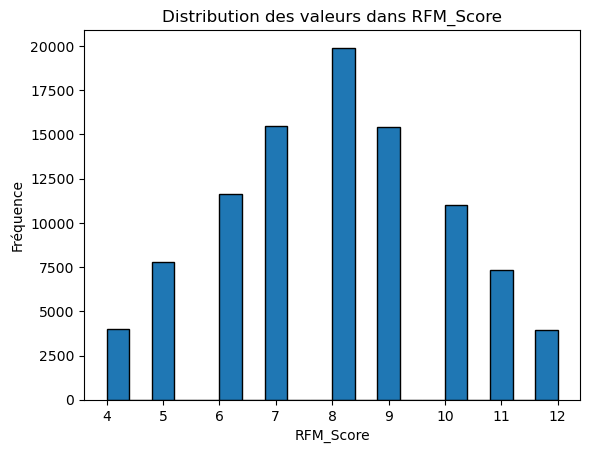

Empty DataFrame
Columns: [customer_id, recency, frequency, monetary, R_Score, F_Score, M_Score, RFM_Score, RFM_Segment]
Index: []
Nombre de valeurs dans chaque score RFM :
 RFM_Score
4      4017
5      7775
6     11629
7     15478
8     19907
9     15445
10    11006
11     7340
12     3919
Name: count, dtype: int64


In [14]:
### Nous passons maintenant à la visualisation des segments

import matplotlib.pyplot as plt

# Visualisation de la distribution des valeurs dans la colonne RFM_Score
plt.hist(rfm_df['RFM_Score'], bins=20, edgecolor='black')
plt.xlabel('RFM_Score')
plt.ylabel('Fréquence')
plt.title('Distribution des valeurs dans RFM_Score')
plt.show()

# Affichage des lignes avec des valeurs manquantes dans la colonne RFM_Segment
missing_segments = rfm_df[rfm_df['RFM_Segment'].isnull()]
print(missing_segments)

# Comptage du nombre de valeurs dans chaque score RFM
rfm_score_counts = rfm_df['RFM_Score'].value_counts().sort_index()

# Affichage du nombre de valeurs dans chaque score RFM
print("Nombre de valeurs dans chaque score RFM :\n", rfm_score_counts)

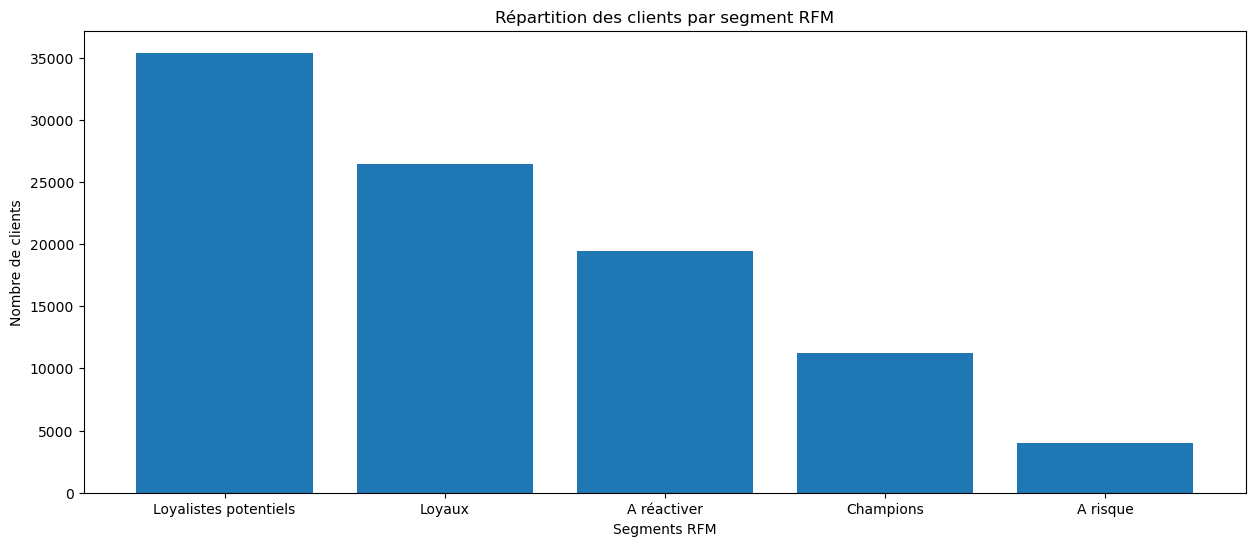

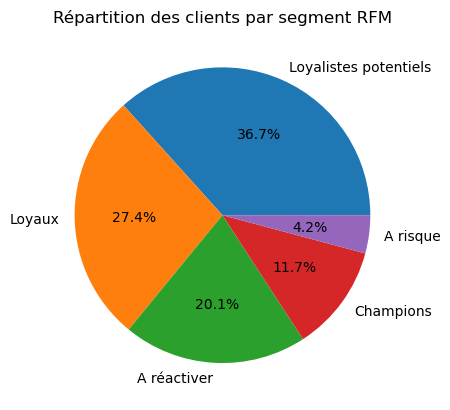

In [15]:
# Création du diagramme en barres
plt.figure(figsize=(15,6))
plt.bar(rfm_df['RFM_Segment'].value_counts().index, rfm_df['RFM_Segment'].value_counts().values)
plt.xlabel('Segments RFM')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par segment RFM')
plt.show()

plt.pie(rfm_df['RFM_Segment'].value_counts(), labels=rfm_df['RFM_Segment'].value_counts().index, autopct='%1.1f%%')
plt.title('Répartition des clients par segment RFM')
plt.show()

Grâce à cela, nous pouvons voir la dispersion de nos clients en fonction de leurs habitudes (récence, fréquence, montant). Cela nous donne une idée du nombre de segments, de leur quantité, etc. Nous pourrons utiliser ces informations par la suite pour nous aider.

Comme nous pouvons le constater la majorité sont des clients potentiel loyalistes et une très faible parti est considéré à risque ici. Les clients considérés comme les meilleurs sont eux présent à 11,7% dans les données au global. 

In [16]:
# Téléchargement du fichier
rfm_df.to_csv('rfm_data.csv', index=False)

Je décide également de vérifier la distribution de la variables de la valeur monétaire pour mieux comprendre. 

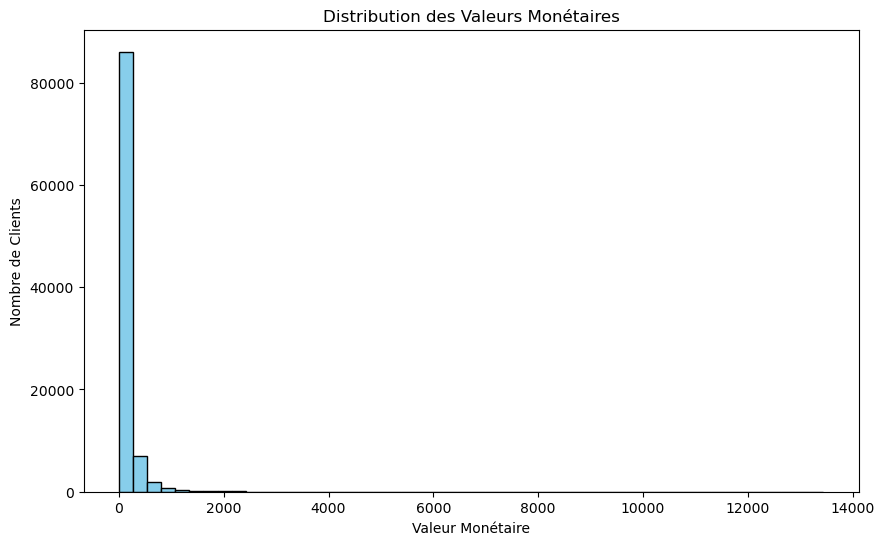

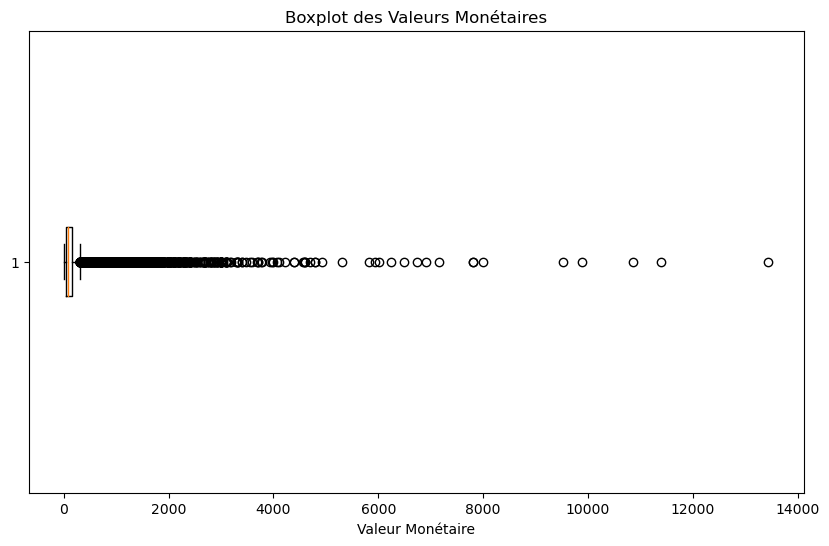

In [17]:
# Visualisation de l'histogramme des valeurs monétaires
plt.figure(figsize=(10, 6))
plt.hist(rfm_df['monetary'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution des Valeurs Monétaires')
plt.xlabel('Valeur Monétaire')
plt.ylabel('Nombre de Clients')
plt.show()

# Vous pouvez également utiliser un boxplot pour visualiser la distribution et détecter les valeurs aberrantes
plt.figure(figsize=(10, 6))
plt.boxplot(rfm_df['monetary'], vert=False)
plt.title('Boxplot des Valeurs Monétaires')
plt.xlabel('Valeur Monétaire')
plt.show()

#### Vérification du nombre de valeurs manquantes: 

In [18]:
nbr_valeurs_manquantes = merged_df.isna().sum().sum()
nbr_valeurs = merged_df.size
pourcentage_valeurs_manquantes = (nbr_valeurs_manquantes / nbr_valeurs ) * 100
pourcentage_valeurs_manquantes

3.26241421035079

Le pourcentage de valeur manquante est relativement faible mais tous de même présents nous allons par la suite pouvoir changer cela de sorte à ne plus avoir aucune valeur nulle.

In [19]:
### L'objectif ici est de visualiser le nombre de valeurs unique par variable

# Calcul du nombre de valeurs uniques pour chaque colonne
unique_counts = merged_df.nunique()

# Création d'un DataFrame pour afficher les résultats
unique_counts_df = pd.DataFrame({'Column': unique_counts.index, 'Unique Values': unique_counts.values})

# Affichage du DataFrame trié par le nombre de valeurs uniques
unique_counts_df = unique_counts_df.sort_values(by='Unique Values', ascending=False)
print(unique_counts_df)

                           Column  Unique Values
19                        index_y         100792
0                        order_id          96516
1                     customer_id          96516
8                         index_y          96516
24                      review_id          96319
29        review_answer_timestamp          96163
3        order_purchase_timestamp          95989
6   order_delivered_customer_date          93702
9              customer_unique_id          93396
16            shipping_limit_date          91386
4               order_approved_at          88332
5    order_delivered_carrier_date          79241
27         review_comment_message          35176
30                        index_y          32171
14                     product_id          32171
23                  payment_value          28657
10       customer_zip_code_prefix          14907
18                  freight_value           6954
17                          price           5879
26           review_

In [20]:
### On fait de même mais pour les variables de type object seulement

# Filtrer les colonnes de type 'object'
object_columns = merged_df.select_dtypes(include='object').columns

# Calcul du nombre de valeurs uniques pour chaque colonne
unique_counts_object = merged_df[object_columns].nunique()

# Création d'un DataFrame pour afficher les résultats
unique_counts_object_df = pd.DataFrame({'Column': unique_counts_object.index, 'Unique Values': unique_counts_object.values})

# Affichage du DataFrame trié par le nombre de valeurs uniques
unique_counts_object_df = unique_counts_object_df.sort_values(by='Unique Values', ascending=False)
print(unique_counts_object_df)

                           Column  Unique Values
0                        order_id          96516
1                     customer_id          96516
14                      review_id          96319
18        review_answer_timestamp          96163
3        order_purchase_timestamp          95989
7              customer_unique_id          93396
12            shipping_limit_date          91386
4               order_approved_at          88332
5    order_delivered_carrier_date          79241
16         review_comment_message          35176
10                     product_id          32171
15           review_comment_title           4477
8                   customer_city           4093
11                      seller_id           3028
17           review_creation_date            632
20                    seller_city            604
6   order_estimated_delivery_date            449
19          product_category_name             71
22  product_category_name_english             71
9                  c

In [21]:
### Nous allons maintenant pouvoir commencer à nettoyer notre data frame en commmencant par supprimer les colonnes non nécessaires

# Affichage de la liste des colonnes actuelles
print(merged_df.columns)

# Liste des colonnes à supprimer
columns_to_drop = [
    'review_id', 'geolocation_city', 'index_geoloc', 'index_y', 'index_x',
    'customer_unique_id', 'shipping_limit_date', 'order_approved_at', 'order_delivered_carrier_date',
    'review_comment_message', 'product_id', 'review_comment_title', 'seller_id',
    'review_creation_date', 'order_estimated_delivery_date','product_category_name_english' , 'index_orders','index_customers',
    'seller_zip_code_prefix','customer_zip_code_prefix','index_merged','order_item_id', 'index_order_pymts','index_products','customer_city','seller_city'
]

# Suppression des colonnes du DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')  # utiliser errors='ignore' pour éviter les erreurs si la colonne n'existe pas

# Affichage du DataFrame mis à jour
print(merged_df.head())

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'index_y', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'index_y',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'index_y', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'index_x',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'index_y',
       'product_category_name_e

In [22]:
# Vérification
pourcentage_valeurs_manquantes = (merged_df.isna().sum() / len(merged_df)) * 100
pourcentage_valeurs_manquantes

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_delivered_customer_date    0.000000
customer_state                   0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_score                     0.000000
review_answer_timestamp          0.000000
product_category_name            0.000000
product_name_lenght              0.000000
product_description_lenght       0.000000
product_photos_qty               0.000000
product_weight_g                 0.000865
product_length_cm                0.000865
product_height_cm                0.000865
product_width_cm                 0.000865
seller_state                     0.000000
dtype: float64

In [23]:
merged_df.describe()

,order_delivered_customer_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,115609,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000
mean,2018-01-14 02:58:49.440095488,120.619850,20.056880,1.093747,2.946233,172.387379,4.034409,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167
min,2016-10-11 13:46:32,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,2017-09-28 15:40:18,39.900000,13.080000,1.000000,1.000000,60.870000,4.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,2018-02-02 01:42:36,74.900000,16.320000,1.000000,2.000000,108.050000,5.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,2018-05-14 17:54:49,134.900000,21.210000,1.000000,4.000000,189.480000,5.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,2018-10-17 13:22:46,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000
std,NaN,182.653476,15.836184,0.729849,2.781087,265.873969,1.385584,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083


Ce describe me permet de vérifier les valeurs dans nos variables pour visualiser les potentiels outliers notamment.

### Remplacement des valeurs nulles 

In [24]:
# Convertion de la colonne 'order_delivered_customer_date' en type datetime
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'], errors='coerce')

# Calcul de la date médiane
median_date = merged_df['order_delivered_customer_date'].median()

# Remplacement des valeurs manquantes par la date médiane
merged_df['order_delivered_customer_date'].fillna(median_date, inplace=True)

In [25]:
# Remplacement des valeurs nulles par la moyenne pour les colonnes spécifiques
columns_to_fillna = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

for column in columns_to_fillna:
    mean_value = merged_df[column].mean()
    merged_df[column].fillna(mean_value, inplace=True)

In [26]:
# Vérification
pourcentage_valeurs_manquantes = (merged_df.isna().sum() / len(merged_df)) * 100
pourcentage_valeurs_manquantes

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_delivered_customer_date    0.0
customer_state                   0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_score                     0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
product_length_cm                0.0
product_height_cm                0.0
product_width_cm                 0.0
seller_state                     0.0
dtype: float64

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   customer_id                    115609 non-null  object        
 2   order_status                   115609 non-null  object        
 3   order_purchase_timestamp       115609 non-null  object        
 4   order_delivered_customer_date  115609 non-null  datetime64[ns]
 5   customer_state                 115609 non-null  object        
 6   price                          115609 non-null  float64       
 7   freight_value                  115609 non-null  float64       
 8   payment_sequential             115609 non-null  int64         
 9   payment_type                   115609 non-null  object        
 10  payment_installments           115609 non-null  int64         
 11  

In [28]:
### Nous vérifions de nouveau le nombre de valeurs unique pour les variables de types objects restantes 

# Fitrage des colonnes de type 'object'
object_columns = merged_df.select_dtypes(include='object').columns

# Calcul du nombre de valeurs uniques pour chaque colonne 'object'
unique_counts_object = merged_df[object_columns].nunique()

# Créaation d'un DataFrame pour afficher les résultats
unique_counts_object_df = pd.DataFrame({'Column': unique_counts_object.index, 'Unique Values': unique_counts_object.values})

# Affichage du DataFrame trié par le nombre de valeurs uniques
unique_counts_object_df = unique_counts_object_df.sort_values(by='Unique Values', ascending=False)
print(unique_counts_object_df) 

                     Column  Unique Values
0                  order_id          96516
1               customer_id          96516
6   review_answer_timestamp          96163
3  order_purchase_timestamp          95989
7     product_category_name             71
4            customer_state             27
8              seller_state             23
2              order_status              7
5              payment_type              4


### Création de nouvelles variables : 

#### Montant total des achats par clients

In [29]:
# Calcul du montant total des achats par client
total_purchase_amount_per_customer = merged_df.groupby('customer_id')['payment_value'].sum()

# Fusion des résultats avec le DataFrame d'origine
merged_df = merged_df.merge(total_purchase_amount_per_customer, how='left', on='customer_id', suffixes=('', '_total'))

#### Fréquence d'achat par client 

In [30]:
# Utilisation de la méthode 'groupby' pour obtenir le nombre total d'achats par client
purchase_frequency = merged_df.groupby('customer_id').size().reset_index(name='purchase_frequency')

# Fuision de cette information dans le DataFrame principal
merged_df = pd.merge(merged_df, purchase_frequency, on='customer_id', how='left')

# Affichage des premières lignes du DataFrame avec la nouvelle variable
print(merged_df[['customer_id', 'purchase_frequency']])

                             customer_id  purchase_frequency
0       9ef432eb6251297304e76186b10a928d                   3
1       9ef432eb6251297304e76186b10a928d                   3
2       9ef432eb6251297304e76186b10a928d                   3
3       a20e8105f23924cd00833fd87daa0831                   1
4       26c7ac168e1433912a51b924fbd34d34                   1
...                                  ...                 ...
115604  9d9cfbce48737214f23bf294daf3c6f7                   1
115605  d11524bb77c28efad04e4467eac8a660                   2
115606  d11524bb77c28efad04e4467eac8a660                   2
115607  c3cd86c3cbac654f8558a8286ba93c1c                   2
115608  c3cd86c3cbac654f8558a8286ba93c1c                   2

[115609 rows x 2 columns]


In [31]:
# Vérification
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   customer_id                    115609 non-null  object        
 2   order_status                   115609 non-null  object        
 3   order_purchase_timestamp       115609 non-null  object        
 4   order_delivered_customer_date  115609 non-null  datetime64[ns]
 5   customer_state                 115609 non-null  object        
 6   price                          115609 non-null  float64       
 7   freight_value                  115609 non-null  float64       
 8   payment_sequential             115609 non-null  int64         
 9   payment_type                   115609 non-null  object        
 10  payment_installments           115609 non-null  int64         
 11  

#### Suppression de la colonne order_id

In [32]:
merged_df = merged_df.drop(columns=['order_id'])

### Convertion des colonnes de dates en jours pour faciliter le travail par la suite:

In [33]:
# Convertion de la colonne 'order_purchase_timestamp' en type datetime
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'], errors='coerce')

# Extraction du mois et de l'année pour 'order_purchase_timestamp'
merged_df['purchase_month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['purchase_year'] = merged_df['order_purchase_timestamp'].dt.year

# Affichage des premières lignes des colonnes après extraction
print(merged_df[['purchase_month', 'purchase_year']].head())

   purchase_month  purchase_year
0              10           2017
1              10           2017
2              10           2017
3               8           2017
4               8           2017


#### Je peux donc maintenant les supprimer :

In [34]:
# Liste des colonnes à supprimer
columns_to_drop = ['review_answer_timestamp', 'order_purchase_timestamp', 'order_delivered_customer_date']

# Suppression des colonnes du DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

In [35]:
# Vérification
merged_df

,customer_id,order_status,customer_state,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state,payment_value_total,purchase_frequency,purchase_month,purchase_year
0,9ef432eb6251297304e76186b10a928d,delivered,SP,29.99,8.72,1,credit_card,1,18.12,4,...,4.0,500.0,19.0,8.0,13.0,SP,38.71,3,10,2017
1,9ef432eb6251297304e76186b10a928d,delivered,SP,29.99,8.72,3,voucher,1,2.00,4,...,4.0,500.0,19.0,8.0,13.0,SP,38.71,3,10,2017
2,9ef432eb6251297304e76186b10a928d,delivered,SP,29.99,8.72,2,voucher,1,18.59,4,...,4.0,500.0,19.0,8.0,13.0,SP,38.71,3,10,2017
3,a20e8105f23924cd00833fd87daa0831,delivered,SP,29.99,7.78,1,credit_card,3,37.77,4,...,4.0,500.0,19.0,8.0,13.0,SP,37.77,1,8,2017
4,26c7ac168e1433912a51b924fbd34d34,delivered,SP,29.99,7.78,1,credit_card,1,37.77,5,...,4.0,500.0,19.0,8.0,13.0,SP,37.77,1,8,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,9d9cfbce48737214f23bf294daf3c6f7,delivered,SP,174.00,39.06,1,credit_card,5,213.06,5,...,1.0,7600.0,55.0,15.0,55.0,SC,213.06,1,8,2017
115605,d11524bb77c28efad04e4467eac8a660,delivered,MG,129.00,26.18,1,credit_card,2,55.18,5,...,1.0,2700.0,85.0,7.0,40.0,SC,155.18,2,7,2017
115606,d11524bb77c28efad04e4467eac8a660,delivered,MG,129.00,26.18,2,voucher,1,100.00,5,...,1.0,2700.0,85.0,7.0,40.0,SC,155.18,2,7,2017
115607,c3cd86c3cbac654f8558a8286ba93c1c,delivered,RS,119.99,27.16,1,credit_card,1,47.15,5,...,1.0,3600.0,30.0,30.0,30.0,SP,147.15,2,7,2017


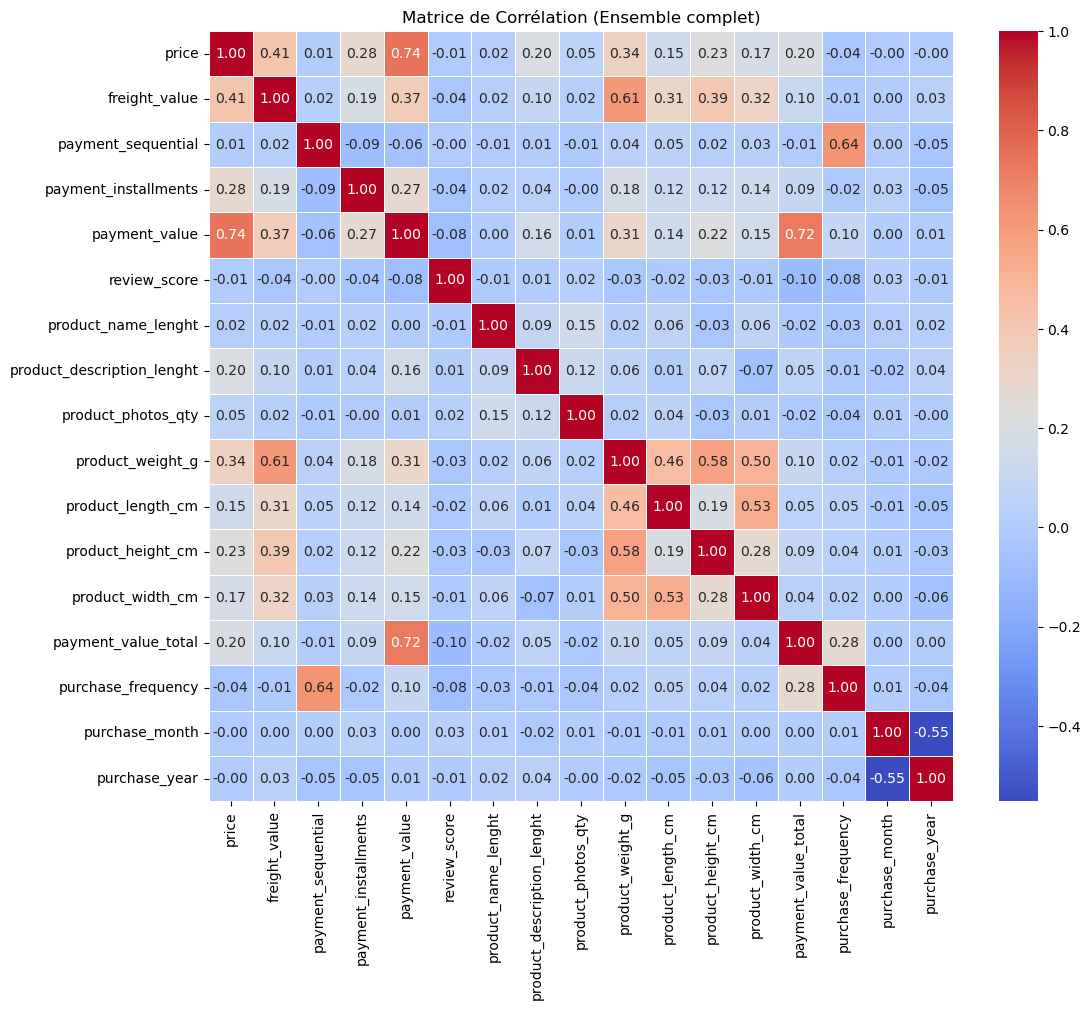

In [36]:
### Ici je décide de mettre en place un heatmap de sorte à visualiser les potentielles corrélation entre les différentes variables

# Sélection des colonnes numériques
numeric_columns = merged_df.select_dtypes(include=['number'])

# Calcul de la matrice de corrélation pour l'ensemble complet de données numériques
correlation_matrix = numeric_columns.corr()

# Création de la matrice de corrélation (heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice de Corrélation (Ensemble complet)')
plt.show()

### Encodage des données : 

#### Mise en place de ordinal encoder 

In [37]:
from sklearn.preprocessing import OrdinalEncoder

# Création d'une instance de l'encodeur ordinal
ordinal_encoder = OrdinalEncoder()

# Adaptation et transformation de la colonne 'product_category_name'
merged_df['product_category_encoded'] = ordinal_encoder.fit_transform(merged_df[['product_category_name']])

# Suppression de la colonne originale
merged_df = merged_df.drop(['product_category_name'], axis=1)

In [38]:
# Vérification
print(merged_df.columns)

Index(['customer_id', 'order_status', 'customer_state', 'price',
       'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_score',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_state',
       'payment_value_total', 'purchase_frequency', 'purchase_month',
       'purchase_year', 'product_category_encoded'],
      dtype='object')


#### Mise en place de one hot encoder

In [39]:

# Sélection des colonnes catégorielles sauf 'customer_id'
categorical_columns = merged_df.select_dtypes(include=['object']).columns.drop('customer_id')

# Application de l'encodage one-hot aux colonnes catégorielles
merged_df_encoded = pd.get_dummies(merged_df, columns=categorical_columns)

# Affichage des premières lignes du DataFrame encodé
merged_df_encoded.head()

,customer_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,9ef432eb6251297304e76186b10a928d,29.99,8.72,1,1,18.12,4,40.0,268.0,4.0,...,False,False,False,False,False,False,False,False,False,True
1,9ef432eb6251297304e76186b10a928d,29.99,8.72,3,1,2.00,4,40.0,268.0,4.0,...,False,False,False,False,False,False,False,False,False,True
2,9ef432eb6251297304e76186b10a928d,29.99,8.72,2,1,18.59,4,40.0,268.0,4.0,...,False,False,False,False,False,False,False,False,False,True
3,a20e8105f23924cd00833fd87daa0831,29.99,7.78,1,3,37.77,4,40.0,268.0,4.0,...,False,False,False,False,False,False,False,False,False,True
4,26c7ac168e1433912a51b924fbd34d34,29.99,7.78,1,1,37.77,5,40.0,268.0,4.0,...,False,False,False,False,False,False,False,False,False,True


In [40]:
# Vérification
merged_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 115609 non-null  object 
 1   price                       115609 non-null  float64
 2   freight_value               115609 non-null  float64
 3   payment_sequential          115609 non-null  int64  
 4   payment_installments        115609 non-null  int64  
 5   payment_value               115609 non-null  float64
 6   review_score                115609 non-null  int64  
 7   product_name_lenght         115609 non-null  float64
 8   product_description_lenght  115609 non-null  float64
 9   product_photos_qty          115609 non-null  float64
 10  product_weight_g            115609 non-null  float64
 11  product_length_cm           115609 non-null  float64
 12  product_height_cm           115609 non-null  float64
 13  product_width_

#### Normalisation des données

In [42]:
print(merged_df_encoded.dtypes)

customer_id              object
price                   float64
freight_value           float64
payment_sequential        int64
payment_installments      int64
                         ...   
seller_state_RO            bool
seller_state_RS            bool
seller_state_SC            bool
seller_state_SE            bool
seller_state_SP            bool
Length: 80, dtype: object


In [43]:
from sklearn.preprocessing import StandardScaler

# Récupération des noms de toutes les colonnes numériques
numeric_columns = merged_df_encoded.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# On exclu les colonnes spécifiques de la normalisation
columns_to_exclude = ['purchase_month', 'purchase_year']

# On copie les colonnes à exclure
columns_to_keep = merged_df_encoded[columns_to_exclude].copy()

# On retire les colonnes à exclure de la liste des colonnes numériques
numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# On retire également temporairement les noms de colonnes
merged_df_encoded.columns = [str(col) for col in merged_df_encoded.columns]

# On initialise StandardScaler
scaler = StandardScaler()

# On applique la transformation avec StandardScaler uniquement aux colonnes numériques
merged_df_encoded[numeric_columns] = scaler.fit_transform(merged_df_encoded[numeric_columns])

# Et on peux maintenant réintégrer les colonnes copiées
merged_df_encoded[columns_to_exclude] = columns_to_keep

In [44]:
# Vérification
merged_df_encoded.head()

,customer_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,9ef432eb6251297304e76186b10a928d,-0.496187,-0.715888,-0.128448,-0.699813,-0.580230,-0.024834,-0.873671,-0.793678,1.044746,...,False,False,False,False,False,False,False,False,False,True
1,9ef432eb6251297304e76186b10a928d,-0.496187,-0.715888,2.611858,-0.699813,-0.640860,-0.024834,-0.873671,-0.793678,1.044746,...,False,False,False,False,False,False,False,False,False,True
2,9ef432eb6251297304e76186b10a928d,-0.496187,-0.715888,1.241705,-0.699813,-0.578462,-0.024834,-0.873671,-0.793678,1.044746,...,False,False,False,False,False,False,False,False,False,True
3,a20e8105f23924cd00833fd87daa0831,-0.496187,-0.775246,-0.128448,0.019333,-0.506322,-0.024834,-0.873671,-0.793678,1.044746,...,False,False,False,False,False,False,False,False,False,True
4,26c7ac168e1433912a51b924fbd34d34,-0.496187,-0.775246,-0.128448,-0.699813,-0.506322,0.696887,-0.873671,-0.793678,1.044746,...,False,False,False,False,False,False,False,False,False,True


In [45]:
# Vérification
merged_df_encoded.describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_total,purchase_frequency,purchase_month,purchase_year,product_category_encoded
count,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,1.156090e+05,115609.000000,115609.000000,1.156090e+05
mean,5.359386e-17,2.020833e-16,4.498934e-17,6.244422e-17,-9.292880e-17,-1.863493e-16,5.162711e-17,6.539434e-17,-5.801904e-17,2.999289e-17,2.036813e-16,9.096206e-17,2.467039e-16,3.466392e-17,1.659443e-17,6.032022,2017.539231,1.130880e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,3.223457,0.505029,1.000004e+00
min,-6.557245e-01,-1.266528e+00,-1.284478e-01,-1.059386e+00,-6.483829e-01,-2.189996e+00,-4.361761e+00,-1.198328e+00,-7.017108e-01,-5.589802e-01,-1.437786e+00,-1.086468e+00,-1.455823e+00,-2.272367e-01,-2.774190e-01,1.000000,2016.000000,-1.688138e+00
25%,-4.419308e-01,-4.405676e-01,-1.284478e-01,-6.998130e-01,-4.194388e-01,-2.483375e-02,-6.743516e-01,-6.741225e-01,-7.017108e-01,-4.796512e-01,-7.592330e-01,-6.411479e-01,-6.901897e-01,-1.881677e-01,-2.774190e-01,3.000000,2017.000000,-1.085226e+00
50%,-2.503103e-01,-2.359720e-01,-1.284478e-01,-3.402398e-01,-2.419855e-01,6.968869e-01,3.222457e-01,-2.848003e-01,-7.017108e-01,-3.738793e-01,-3.274266e-01,-2.700478e-01,-2.648381e-01,-1.489112e-01,-2.774190e-01,6.000000,2018.000000,-2.040463e-01
75%,7.818199e-02,7.281586e-02,-1.284478e-01,3.789065e-01,6.428871e-02,6.968869e-01,8.205443e-01,3.022487e-01,4.625938e-01,-8.300655e-02,4.744996e-01,2.494923e-01,5.858651e-01,-6.060407e-02,1.390697e-01,8.000000,2018.000000,8.626447e-01
max,3.621288e+01,2.460345e+01,3.823583e+01,7.570370e+00,5.074491e+01,6.968869e-01,2.714079e+00,4.914338e+00,1.035918e+01,1.013059e+01,4.607504e+00,6.558194e+00,8.072053e+00,7.299563e+01,2.554488e+01,12.000000,2018.000000,1.558313e+00


In [46]:
#Vérification
print(merged_df_encoded.dtypes)

customer_id              object
price                   float64
freight_value           float64
payment_sequential      float64
payment_installments    float64
                         ...   
seller_state_RO            bool
seller_state_RS            bool
seller_state_SC            bool
seller_state_SE            bool
seller_state_SP            bool
Length: 80, dtype: object


#### Enregistrement du fichier 

In [47]:
merged_df_encoded.to_csv("data_cleaned.csv", index=False)

Une fois toutes ces étapes effectuées, que ce soit l'analyse exploratoire ou le nettoyage proprement dit de notre fichier, nous pouvons passer à l'étape suivante (le clustering). Ces étapes étaient nécessaires au bon fonctionnement des algorithmes que nous allons pouvoir utiliser pour la segmentation.